# Loading up the given data anf previewing:

In [1]:
# importing important modules
import pandas as pd
import numpy as np

# Loading given data
users = pd.read_csv('takehome_users.csv',encoding = "latin-1",parse_dates = True)
engage = pd.read_csv('takehome_user_engagement.csv',parse_dates = True)


In [2]:
# Display data
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
# Display data
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
users.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

In [7]:
engage.columns

Index(['time_stamp', 'user_id', 'visited'], dtype='object')

# Labelling users as Adopted

In [8]:
# Set time_stamp to datetime and set it as index 
import datetime
engage.time_stamp = pd.to_datetime(engage.time_stamp)
engage = engage.set_index('time_stamp', drop = True)

### Keeping users who have logged at least 3 days:

In [9]:
from datetime import timedelta
def label_adopted(x):
    "takes a users input and return whether or not they have been active within any 7-day period"
    df_temp = engage.loc[engage['user_id'] == x] #select out rows of this user
    df_temp = df_temp.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    adopted = 0
    for i in range(len(df_temp)-2): #loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [10]:
#applying the user df to label users as adopted=true 
users['adopted_user'] = users['object_id'].apply(label_adopted)

### Showing the active users

In [11]:
print(sum(users['adopted_user']))
print(sum(users.adopted_user)/len(users.adopted_user))

1656
0.138


#### By Subtract the creation_time from the last_session_creation_time to create a feature that combines the two in a meaningful way. This will give us feature usage_length that basically indicates how long a user has been active.

In [12]:
# set creation_time
users.creation_time = pd.to_datetime(users.creation_time)
#last_session_creation_time is a unix time stamp, so use map to convert to datetime
users['last_session_creation_time'] = users['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),
                                                                              na_action='ignore')

In [13]:
#now set that to datetime
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])
#subtract to find time active
users['usage_length'] = users['last_session_creation_time'] - users['creation_time']
#lets settle for seconds instead of days to make the time differences more distinct
users['usage_length'] = [x.total_seconds() for x in users['usage_length']]

#### we can also use email domain as a feature as well. There are only a few main ones, so I will label the less popular domains as other.

In [14]:
users['email_provider'] = [x.split('@')[1] for x in users.email]#select out the domain
top_emails = users.email_provider.value_counts().index[:6]
#label anything not in the top 5 as other
users['email_provider'] = [x if x in top_emails else 'other' for x in users.email_provider]

##### first the emtpy values must be filled to be categorized.

In [15]:
users.invited_by_user_id = users.invited_by_user_id.fillna(0)

##### remove the columns containing features that won't be useful for analysis
##### This includes object_id creation_time name email and last_session_creation_time.

In [16]:
feature_df = users.iloc[:,4:]
feature_df = feature_df.drop('last_session_creation_time', axis=1)
feature_df['usage_length'] = feature_df['usage_length'].fillna(0)

In [ ]:
##### labelling the each category

In [17]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
creation_labels = gle.fit_transform(users['creation_source'])
feature_df.creation_source = creation_labels

org_id_labels = gle.fit_transform(users['org_id'])
feature_df.org_id = org_id_labels

invited_labels = gle.fit_transform(users['invited_by_user_id'])
feature_df.org_id = invited_labels

email_labels = gle.fit_transform(users['email_provider'])
feature_df.email_provider = email_labels

In [18]:
feature_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,usage_length,email_provider
0,0,1,0,2325,10803.0,0,19800.0,6
1,1,0,0,56,316.0,1,11770200.0,2
2,1,0,0,298,1525.0,0,19800.0,2
3,0,0,0,1104,5151.0,0,106200.0,6
4,0,0,0,1127,5240.0,0,451800.0,6


##### Seperating out the labels

In [19]:
from sklearn.model_selection import train_test_split

#set up data by seperating out the labels, then split for cross validation
data = feature_df.drop('adopted_user', axis=1)
labels = feature_df.adopted_user

X_train, y_train, X_test, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [20]:
from sklearn.ensemble import RandomForestClassifier

#train and test classifier
rf = RandomForestClassifier(class_weight='balanced_subsample')

rf.fit(X_train, X_test)

rf.score(y_train, y_test)

0.9709595959595959

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

#print out classification report and confusion matrix
y_pred = rf.predict(y_train)

print(classification_report(y_test, y_pred))

cm= confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3407
           1       0.91      0.88      0.89       553

    accuracy                           0.97      3960
   macro avg       0.95      0.93      0.94      3960
weighted avg       0.97      0.97      0.97      3960

confusion matrix:
[[3360   47]
 [  68  485]]


##### Feature Importance

In [22]:
#make a df that displays the cofficients indexed by feature name
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(data.columns)
feature_importance.coef.nlargest(10)

usage_length                  0.919525
org_id                        0.023335
invited_by_user_id            0.022975
email_provider                0.015930
creation_source               0.011115
opted_in_to_mailing_list      0.003787
enabled_for_marketing_drip    0.003333
Name: coef, dtype: float64

##### Plotting the results

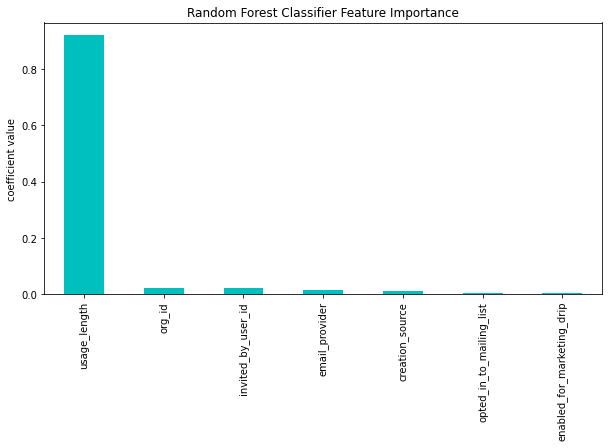

In [24]:
#plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index, color = 'c')
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('coefficient value')
plt.show()

In [25]:
#define func to find ecdf of dataset
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [26]:
adopted = feature_df.usage_length.loc[feature_df['adopted_user'] == 1]
not_adopted = feature_df.usage_length.loc[feature_df['adopted_user'] == 0]

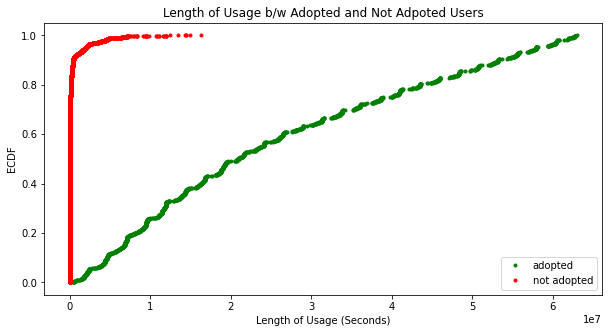

In [28]:
#set fig size
%matplotlib inline
plt.figure(figsize=(10,5))

x_active, y_active = ecdf(adopted)
x_inactive, y_inactive = ecdf(not_adopted)

plt.plot(x_active, y_active, marker='.', linestyle='none',color = 'g')
plt.plot(x_inactive, y_inactive, marker='.', linestyle='none', color = 'r')
plt.title('Length of Usage b/w Adopted and Not Adpoted Users')
plt.xlabel('Length of Usage (Seconds)')
plt.ylabel('ECDF')
plt.legend(['adopted', 'not adopted'])
plt.show()